In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, UpSampling2D, Conv2D, Activation, Dropout, Flatten
from tensorflow.keras.layers import Input

import warnings
warnings.filterwarnings('ignore')

### 생성자 모델 생성
# 가상 이미지를 만들어 내는 공장으로, 처음엔 랜덤한 픽셀값으로 채워진 가짜 이미지로 시작
# 판별자의 판별 결과에 따라 지속적 업데이트하여 점차 원하는 이미지 생성
    # 판별과 학습이 생성자에 일어나는게 아니므로 Optimizer 사용하는 최적화 과정 / 컴파일 과정 없음
    # 일부 매개 변수 삭제하는 풀링 과정 없음
    # 입출력 크기 맞추기 위해 빈곳 채워서 같은 크기로 맞추는 패딩 과정 포함, 마스크 이용하여 컨볼루션 층 생성시 이미지 크기가 처음보다 줄어듬(차원 축소 문제)
generator = Sequential()

# 128은 임의로 정한 노드수, 100차원 크기의 랜덤 백터 입력
# 7*7은 이미지 최초 크기로 UpSampling2D()함수 사용시 가로/세로 2배씩 늘어남
# MNIST 손글씨 이미지 크기는 28x28이므로 7x7(이미지 최초크기) -> 14x14(UpSampling2D) -> 28x28(UpSampling2D)로 이미지 크기 늘어날 예정
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))

# BatchNormalization는 배치정규화로 다음층으로 입력될 값을 정규 분포(평균0 분산1)되도록 일정하게 재배치 역할
# 이 과정을 통해 층 개수가 늘어나도 안정적인 학습 진행 가능
generator.add(BatchNormalization())

# 컨볼루션 레이어가 받아들일 수 있는 형태로 변형, Conv2D() 함수의 input_shape 부분에 들어갈 형태 설정
generator.add(Reshape((7, 7, 128)))

# UpSampling2D : 이미지 크기 가로/세로 2배씩 증가
generator.add(UpSampling2D())

# 컨볼루션 과정 처리, 커널 크기 3으로 해서 3x3 크기의 마스크 착용
# padding='same' : 모자 부분 자동으로 0 채워짐
generator.add(Conv2D(128, kernel_size=3, padding='same'))
generator.add(BatchNormalization())

# LeakyReLU(럭키렐루): ReLU()함수에서 x값 음수이면 무조건 0이 되어 뉴런 일찍 소실되는 단점 보완위해 0이하에서도 작은 값 갖게 만드는 활성화 함수
# LeakyReLU(0.2) : 0보다 작을 경우 0.2 곱하라는 의미
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())

# 한번더 컨볼루션 과정 거친후, 판별자로 값 넘길 활성화 함수는 tanh
# tanh() : 출력값을 -1~1사이로 변환
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))



### 판별자 모델 생성
# 생성자에서 넘어온 이미지가 가짜/진짜 판별해주는 역할로 컨볼루션 신경망 구조를 그대로 가지고 와서 생성
# 진짜/가짜만 판별할 뿐 자기자신이 학습 해서는 안됨
# # 판별자가 얻은 가중치는 판별자 자신이 학습시 쓰이는게 아니라 생성자로 넘겨 생성자가 업데이트된 이미지 생성 하도록 해야함
discriminator = Sequential()

# 노드 개수 64, 커널 크기 5(마스크 5x5)
# stride : 마스크를 몇칸씩 이동시킬지 설정, default는 1칸이며 stride=2는 마스크 2칸씩 이동
    # 마스크 여러칸 움직이는 이유는 가로/세로 크키가 더 줄어들어 새로운 특징 뽑아주는 효과가 생김, 드롭아웃/풀링처럼 새로운 필터 적용한 효과와 동일
    # 판별자는 진짜/가짜만 구분하면 되므로 Upsamling으로 가로/세로 늘려주는것 대신 stride/드롭아웃 등 차원 줄여주는 기능 사용
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))

discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

# Faltten() : 어떤 차원의 데이터든 1차원 형태로 변환
# 컨볼루션층 또는 맥스풀링은 이미지를 2차원 배열로 다룸
# 활성화 함수(sigmoid)를 사용하기 위해서는 1차원 배열이어야 하므로 Flatten()함수 사용
discriminator.add(Flatten())

# 판별결과가 진짜(1)/가짜(0), 둘중 하나가 되어야 하므로 마지막 활성화 함수 sigmoid() 함수 사용
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# 판별이 끝나고 판별자 자신이 학습되지 않게 학습 기능 오프
discriminator.trainable = False



### 생성자와 판별자 모델 연결시키는 gan 모델 생성
# 생성자에서 나온 출력을 판별자에 넣어 진위 여부 판별
# 판별자가 더 구별하지 못하게 되어 정확도 0.5에 가까워질 경우, 생성자 역할 및 학습 종료

# 랜덤 100개 벡터를 케라스의 Input() 함수에 집어넣어 생성자에 입할 ginput 생성
ginput = Input(shape=(100,))

# 생성자 모델 generator()에 ginput 입력하여 출력되는 28x28 크기 이미지가 그대로 판별자 모델 discriminator()입력 값으로 입력
# 판별자는 이 입력값을 가지고 참/거짓 판별하는데, 그 결과를 dis_output이라 지정
dis_output = discriminator(generator(ginput))

# gitput값과 dis_output값을 넣어 gan이라는 새로운 모델 생성
gan = Model(ginput, dis_output)

# 참/거짓 구분 이진로스함수(binary_crossentropy)와 최적화함수(adam)함수 사용하여 모델 컴파일
gan.compile(loss='binary_crossentropy', optimizer='adam')

gan.summary()



### 신경망 실행 함수 생성
# batch_size : 한번에 몇개 실제 이미지와 가상 이미지를 판별자에 입력할지 설정 인자
# saving_interval : 몇번마다 한번씩 저장할지 설정 인자
def gan_train(epoch, batch_size, saving_interval):

# MNIST 데이터 로드, 테스트 과정 필요없고 이미지만 사용할 것이므로 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()

    # 가로28, 세로28이고 흑백이므로 1 설정
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # 생성자에서 출력값 생성할 때 tanh() 함수 사용, 데이터 픽셀 값을 -1~1 사이 값으로 지정
    # 0~255까지 값으로 되어 있는 픽셀값을 -1~1로 바꾸려면 현재 픽셀값에서 127.5 뺀 뒤 127.5로 나눠야 함
    X_train = (X_train-127.5) / 127.5

    # 모두 참(1) 이라는 레이블 값을 가진 배열과 모두 거짓(0) 이라는 레이블 값을 가진 배열 생성
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):

        ## 실제 데이터를 판별자에 입력
        # 넘파이 random()함수 사용하여 실제 이미지를 랜덤하게 선택 호출
        # np.random.randint(a, b, c) : a부터 b까지의 숫자 중 하나를 랜덤하게 선택해 가져오는 과정을 c번 반복
        idx = np.random.randint(0, X_train.shape[0], batch_size)

        # 선택된 숫자에 해당하는 이미지 호출
        imgs = X_train[idx]

        # 판별자 모델에 train_on_batch()함수 써서 판별 시작
        # train.on_batch(x, y) : 입력값(x)와 레이블(y)를 받아 딱 한번 학습 실시해 모델 업데이트
        d_loss_real = discriminator.train_on_batch(imgs, true)

        ### 가상 이미지를 판별자에 입력
        # 생성자에 넣을 가상 이미지 생성
        # 정수가 아니므로 np.ramdom.normal(a, b, c) 사용 : a부터 b까지 실수 중 c개 랜덤 추출, (batch_size, 100)은 batch_size만큼 100열 추출
        noise = np.random.normal(0, 1, (batch_size, 100))

        # 위에서 만들어진 값이 생성자에 들어가고 결과값이 gen_imgs에 저장
        gen_imgs = generator.predict(noise)

        # 위에서 만든 값에 모두 가짜라는 레이블이 붙어서 판별자에 입력
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        ### 판별자와 생성자의 오차 계산
        # d_loss_real(실제 이미지), d_loss_fake(가상 이미지)가 판별자 안에서 번갈아가며 진위 판단 시작
        # 각각 계산되는 오차 평균 구하면 판별자의 오차 d_loss 계산 가능
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)

        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)


        ### 중간 과정을 이미지로 저장하는 부분
        # 정해진 인터벌만큼 학습되면 그떄 만들 이미지를 폴더에 저장
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
 
            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
    
            fig, axs = plt.subplots(5, 5)  
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("../images/gan//gan_mnist_%d.png" % i)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         809857    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 212865    
Total params: 1,022,722
Trainable params: 797,057
Non-trainable params: 225,665
_________________________________________________________________


2022-06-14 16:00:52.266035: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-14 16:00:52.287061: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2300000000 Hz


epoch:0 d_loss:0.6801 g_loss:0.5936
epoch:1 d_loss:0.5019 g_loss:0.1191
epoch:2 d_loss:0.5971 g_loss:0.0369
epoch:3 d_loss:0.5983 g_loss:0.0865
epoch:4 d_loss:0.5316 g_loss:0.2603
epoch:5 d_loss:0.4684 g_loss:0.5356
epoch:6 d_loss:0.4497 g_loss:0.8255
epoch:7 d_loss:0.4323 g_loss:1.0571
epoch:8 d_loss:0.4166 g_loss:1.1957
epoch:9 d_loss:0.3425 g_loss:1.4721
epoch:10 d_loss:0.2803 g_loss:1.7985
epoch:11 d_loss:0.1778 g_loss:2.4617
epoch:12 d_loss:0.1295 g_loss:3.3688
epoch:13 d_loss:0.1200 g_loss:4.3098
epoch:14 d_loss:0.0783 g_loss:5.0176
epoch:15 d_loss:0.0383 g_loss:5.6933
epoch:16 d_loss:0.0389 g_loss:6.3545
epoch:17 d_loss:0.0275 g_loss:7.2873
epoch:18 d_loss:0.0865 g_loss:7.9803
epoch:19 d_loss:0.2627 g_loss:8.7294
epoch:20 d_loss:1.1530 g_loss:9.4008
epoch:21 d_loss:1.8042 g_loss:6.2464
epoch:22 d_loss:3.0146 g_loss:5.2489
epoch:23 d_loss:2.3164 g_loss:3.3729
epoch:24 d_loss:1.5527 g_loss:1.4077
epoch:25 d_loss:0.8013 g_loss:1.0481
epoch:26 d_loss:0.6714 g_loss:0.7112
epoch:27 d_

2022-06-14 16:09:57.031009: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled
2022-06-14 16:09:57.167010: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch:2617 d_loss:0.6197 g_loss:1.4613
epoch:2618 d_loss:0.6172 g_loss:1.4759
epoch:2619 d_loss:0.4576 g_loss:1.6590
epoch:2620 d_loss:0.5551 g_loss:1.2804
epoch:2621 d_loss:0.5185 g_loss:1.3253
epoch:2622 d_loss:0.5630 g_loss:1.1441
epoch:2623 d_loss:0.5457 g_loss:1.2091
epoch:2624 d_loss:0.5741 g_loss:1.1871
epoch:2625 d_loss:0.5350 g_loss:1.5805
epoch:2626 d_loss:0.4964 g_loss:1.6133
epoch:2627 d_loss:0.4552 g_loss:1.8192
epoch:2628 d_loss:0.3842 g_loss:2.0100
epoch:2629 d_loss:0.5193 g_loss:1.5383
epoch:2630 d_loss:0.5711 g_loss:1.4126
epoch:2631 d_loss:0.4470 g_loss:1.2539
epoch:2632 d_loss:0.5785 g_loss:1.4973
epoch:2633 d_loss:0.4193 g_loss:1.3991
epoch:2634 d_loss:0.3429 g_loss:1.9210
epoch:2635 d_loss:0.4509 g_loss:1.8895
epoch:2636 d_loss:0.4630 g_loss:1.7112
epoch:2637 d_loss:0.4494 g_loss:1.4794
epoch:2638 d_loss:0.3881 g_loss:1.8379
epoch:2639 d_loss:0.4906 g_loss:1.5012
epoch:2640 d_loss:0.4084 g_loss:1.9646
epoch:2641 d_loss:0.5024 g_loss:1.8349
epoch:2642 d_loss:0.3789 

2022-06-14 16:10:12.814967: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch:2702 d_loss:0.6865 g_loss:1.1915
epoch:2703 d_loss:0.4635 g_loss:1.6048
epoch:2704 d_loss:0.4883 g_loss:1.7695
epoch:2705 d_loss:0.4257 g_loss:1.8972
epoch:2706 d_loss:0.5713 g_loss:1.8027
epoch:2707 d_loss:0.4886 g_loss:1.7659
epoch:2708 d_loss:0.3802 g_loss:1.5321
epoch:2709 d_loss:0.4926 g_loss:1.8060
epoch:2710 d_loss:0.6430 g_loss:1.2517
epoch:2711 d_loss:0.5740 g_loss:1.3500
epoch:2712 d_loss:0.4916 g_loss:1.2244
epoch:2713 d_loss:0.4104 g_loss:1.8130
epoch:2714 d_loss:0.5566 g_loss:1.4814
epoch:2715 d_loss:0.5310 g_loss:1.6343
epoch:2716 d_loss:0.5852 g_loss:1.6571
epoch:2717 d_loss:0.4382 g_loss:1.5183
epoch:2718 d_loss:0.5326 g_loss:1.3190
epoch:2719 d_loss:0.4476 g_loss:1.5560
epoch:2720 d_loss:0.6127 g_loss:1.4203
epoch:2721 d_loss:0.5582 g_loss:1.5016
epoch:2722 d_loss:0.5734 g_loss:1.4755
epoch:2723 d_loss:0.6132 g_loss:1.3008
epoch:2724 d_loss:0.5518 g_loss:1.4481
epoch:2725 d_loss:0.4858 g_loss:1.5485
epoch:2726 d_loss:0.5463 g_loss:1.6367
epoch:2727 d_loss:0.4947 

2022-06-14 16:11:51.666990: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch:3213 d_loss:0.4663 g_loss:1.7166
epoch:3214 d_loss:0.6083 g_loss:1.5594
epoch:3215 d_loss:0.5799 g_loss:1.2463
epoch:3216 d_loss:0.5770 g_loss:1.1815
epoch:3217 d_loss:0.5643 g_loss:1.0838
epoch:3218 d_loss:0.4321 g_loss:1.2905
epoch:3219 d_loss:0.4426 g_loss:1.5204
epoch:3220 d_loss:0.4437 g_loss:1.7789
epoch:3221 d_loss:0.5370 g_loss:1.7447
epoch:3222 d_loss:0.4755 g_loss:1.7813
epoch:3223 d_loss:0.3823 g_loss:2.2788
epoch:3224 d_loss:0.4394 g_loss:1.8752
epoch:3225 d_loss:0.3774 g_loss:1.8468
epoch:3226 d_loss:0.3987 g_loss:1.6713
epoch:3227 d_loss:0.4423 g_loss:1.7440
epoch:3228 d_loss:0.3554 g_loss:1.9643
epoch:3229 d_loss:0.3470 g_loss:1.9192
epoch:3230 d_loss:0.2383 g_loss:1.9449
epoch:3231 d_loss:0.3344 g_loss:2.2335
epoch:3232 d_loss:0.3628 g_loss:2.1301
epoch:3233 d_loss:0.3871 g_loss:1.8117
epoch:3234 d_loss:0.5518 g_loss:2.0951
epoch:3235 d_loss:0.3973 g_loss:1.7748
epoch:3236 d_loss:0.4661 g_loss:1.9509
epoch:3237 d_loss:0.3950 g_loss:1.6642
epoch:3238 d_loss:0.5086 

2022-06-14 16:13:32.003007: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


epoch:3728 d_loss:0.5144 g_loss:2.3301
epoch:3729 d_loss:0.4737 g_loss:1.9617
epoch:3730 d_loss:0.5434 g_loss:2.1514
epoch:3731 d_loss:0.6361 g_loss:1.6182
epoch:3732 d_loss:0.5439 g_loss:1.4922
epoch:3733 d_loss:0.4885 g_loss:1.9101
epoch:3734 d_loss:0.4824 g_loss:1.9917
epoch:3735 d_loss:0.6152 g_loss:1.4671
epoch:3736 d_loss:0.7038 g_loss:1.3363
epoch:3737 d_loss:0.4685 g_loss:1.6734
epoch:3738 d_loss:0.5056 g_loss:1.6538
epoch:3739 d_loss:0.6288 g_loss:1.7140
epoch:3740 d_loss:0.5410 g_loss:1.6392
epoch:3741 d_loss:0.6262 g_loss:1.7602
epoch:3742 d_loss:0.5693 g_loss:1.4806
epoch:3743 d_loss:0.3927 g_loss:1.7015
epoch:3744 d_loss:0.4857 g_loss:1.5858
epoch:3745 d_loss:0.4231 g_loss:1.7534
epoch:3746 d_loss:0.4586 g_loss:1.7383
epoch:3747 d_loss:0.5453 g_loss:1.9702
epoch:3748 d_loss:0.5245 g_loss:1.5625
epoch:3749 d_loss:0.5828 g_loss:1.1993
epoch:3750 d_loss:0.4463 g_loss:1.6506
epoch:3751 d_loss:0.3932 g_loss:1.6991
epoch:3752 d_loss:0.4580 g_loss:1.7530
epoch:3753 d_loss:0.4715 

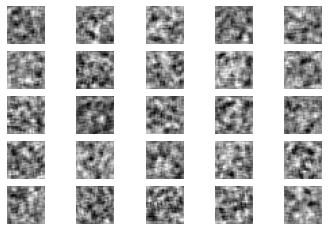

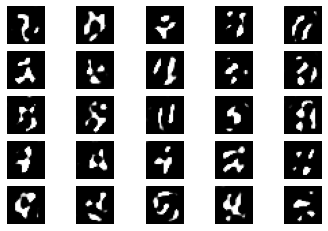

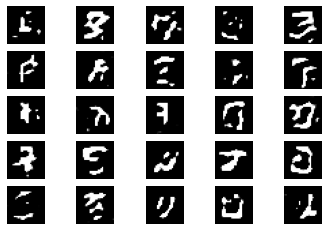

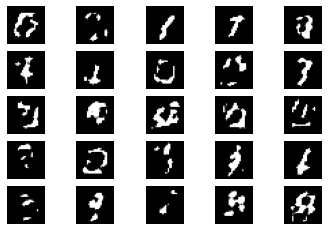

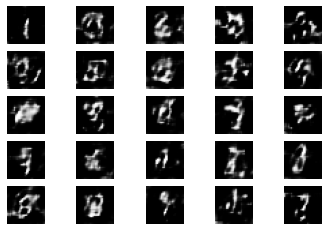

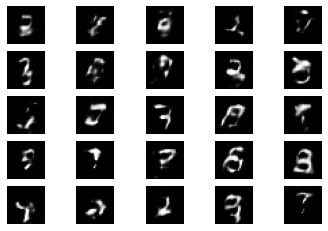

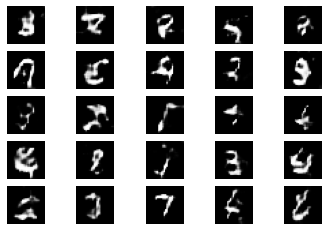

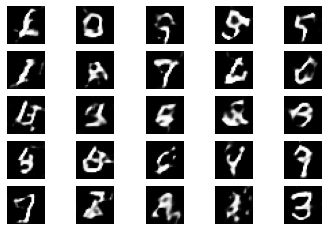

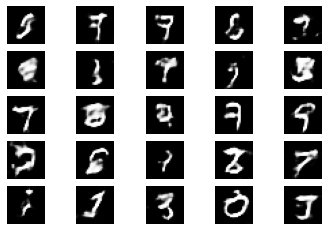

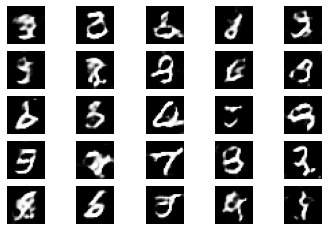

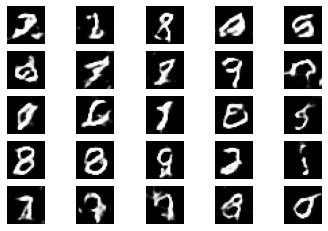

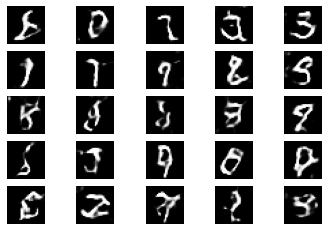

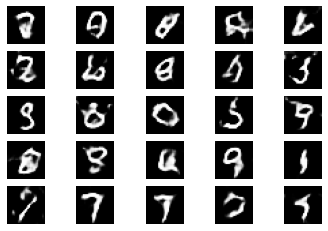

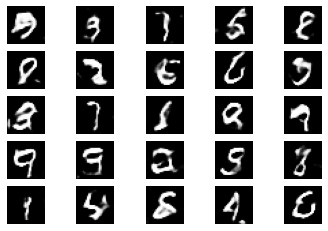

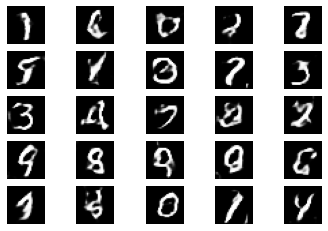

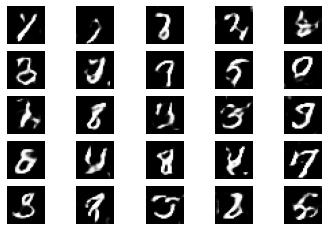

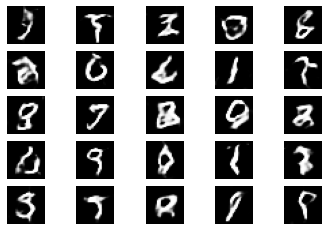

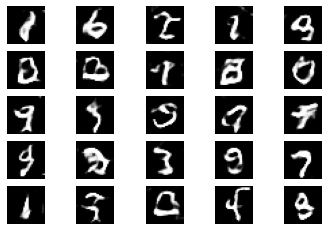

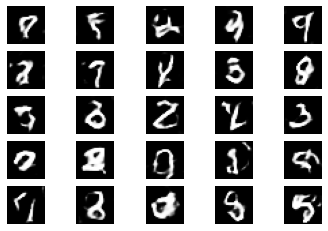

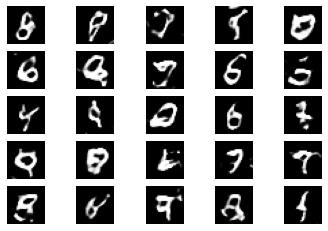

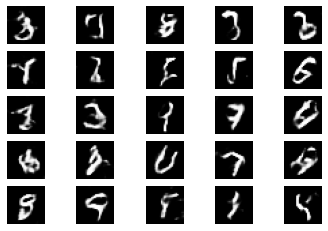

In [3]:
# 4000번 반복되고 +1 하는거 필수, 배치 크기는 32, 200번 마다 결과(이미지 파일) 저장
gan_train(4001, 32, 200)